In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None
Mr. –> 647 males, Age average is 33.11839530332681
Sir. –> 3 males, Age average is 35.5
Dr. –> 11 males, Age average is 39.44444444444444
Major. –> 2 males, Age average is 48.5
Master. –> 40 males, Age average is 4.574166666666667
————————————————————-
Ms. –> 1 females, Age averag

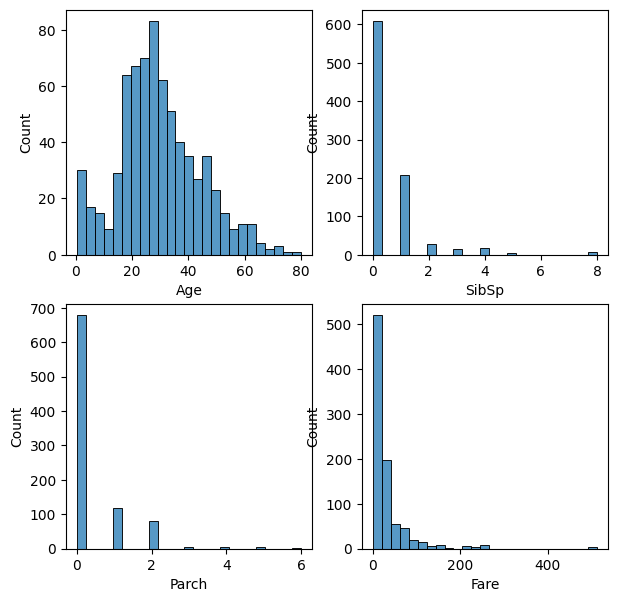

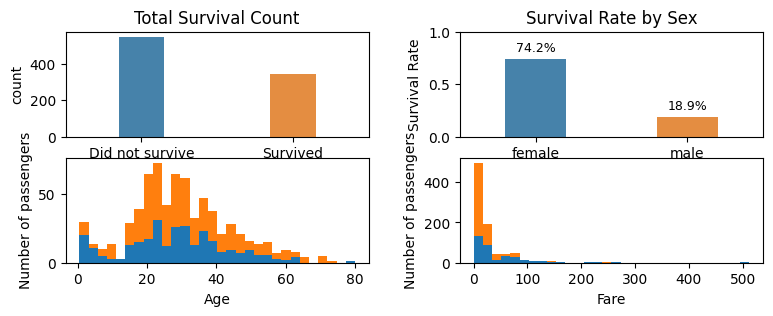

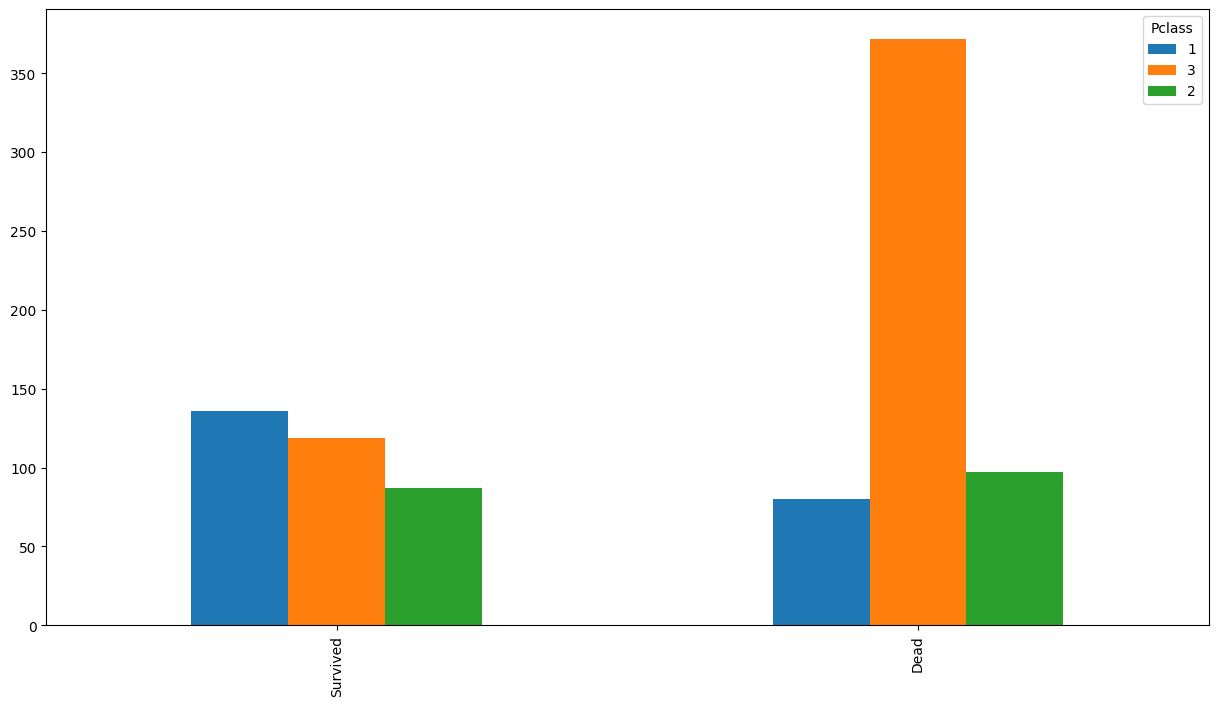

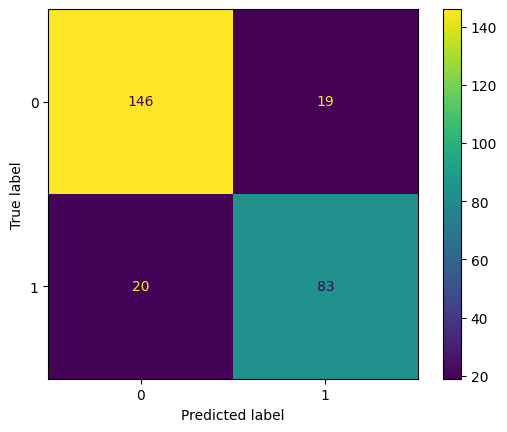

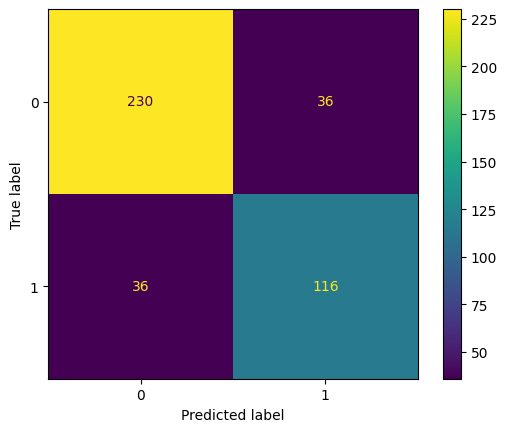

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, naive_bayes
from xgboost import XGBClassifier


# 資料前處理
def preprocessor(data):
    # sex
    data["Sex"] = data["Sex"].map({"male":0, "female":1})

    #cabin
    data['Cabin_Class'] = data['Cabin'].str[:1]
    data['Cabin_Class'] = data['Cabin_Class'].fillna('X')   # nan -> X

    # 擷取稱謂
    dataset_title = [i.split(",")[1].split(".")[0].strip() for i in data["Name"]]
    data["Title"] = pd.Series(dataset_title)
    data["Title"] = data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data["Title"] = data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
    data["Title"] = data["Title"].astype(int)
    # 把不重要的資料刪掉

    col_lst = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    data.drop(col_lst, axis = 1, inplace=True)

    #將空值填入該資料的平均值
    #print(f"isnull:\n{data.isnull().sum()}") #Embarked 跟 Age 有空值
    age_median = data[(data['Age']>0) & (data['Age'].isnull() == False)]['Age'].median()
    data['Age'].fillna(age_median, inplace=True)
    data['Embarked'] = data['Embarked'].fillna('X')   # nan -> X

    # one hot encode
    categorical = ['Pclass', 'Cabin_Class', 'Parch', 'SibSp', 'Embarked']
    ohe = pd.get_dummies(data[categorical]).astype(int)
    data = pd.concat([data, ohe], axis=1)
    data.drop(columns=categorical, inplace=True)


    return data


### main
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
Y_test = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

ids = test.copy()
print(ids.info())

import matplotlib.pyplot as plt
import seaborn as sns

# 資料圖示
numerical = ['Age', 'SibSp', 'Parch', 'Fare']
fig, ax = plt.subplots(2, 2, figsize=(7,7))
sns.histplot(x=train['Age'], bins=25, ax=ax[0][0])
sns.histplot(x=train['SibSp'], bins=25, ax=ax[0][1])
sns.histplot(x=train['Parch'], bins=25, ax=ax[1][0])
sns.histplot(x=train['Fare'], bins=25, ax=ax[1][1])


# 存活率
fig= plt.figure(figsize=(9,3))

# 整體存活率
ax1= plt.subplot(2,2,1)
sns.countplot(data=train, x='Survived', width= 0.3, alpha= 0.9)
plt.xticks(ticks=[0, 1], labels=['Did not survive', 'Survived'])
plt.title("Total Survival Count")
plt.xlabel("")

# 性別存活率
ax2= plt.subplot(2,2,2)
sex_survival_rate = train.groupby('Sex')['Survived'].mean().reset_index()
sns.barplot(x='Sex', y='Survived', data=sex_survival_rate, alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Survival Rate by Sex')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 1])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.3)

# 稱位分佈、存活率
for title in ["Mr.", "Sir.", "Dr.", "Major.", "Master."]:
    num = train[(train['Name'].str.contains(title))]["Name"].count()
    age = train[(train['Name'].str.contains(title))]["Age"].mean()
    print("{} –> {} males, Age average is {}".format(title, num, age))

print("————————————————————-")

for title in ["Ms.", "Miss.", "Mrs.", "Lady."]:
    num = train[(train['Name'].str.contains(title))]["Name"].count()
    age = train[(train['Name'].str.contains(title))]["Age"].mean()
    print("{} –> {} females, Age average is {}".format(title, num, age))
print("="*20)
# 稱位存活率
for title in ["Mr.", "Sir.", "Dr.", "Major.", "Master."]:
    num_survived = train[(train['Survived']==1) & (train['Name'].str.contains(title))]["Name"].count()
    num_died = train[(train['Survived']==0) & (train['Name'].str.contains(title))]["Name"].count()
    #print(num_survived, num_died)
    print("{} total:{} –> {} survived, {} died. {}% survived".format(title, num_survived+num_died, num_survived, num_died, (100*num_survived/(num_survived+num_died))))

print("————————————————————-")

for title in ["Ms.", "Miss.", "Mrs.", "Lady."]:
    num_survived = train[(train['Survived']==1) & (train['Name'].str.contains(title))]["Name"].count()
    num_died = train[(train['Survived']==0) & (train['Name'].str.contains(title))]["Name"].count()
    print("{} total:{} –> {} survived, {} died. {}% survived".format(title, num_survived+num_died, num_survived, num_died, (100*num_survived/(num_survived+num_died))))


# 不同年齡生存率
ax3= plt.subplot(2,2,3)

plt.hist([train[train['Survived']==1]['Age'], train[train['Survived']==0]['Age']], stacked=True, color = ['#1f77b4', '#ff7f0e'], bins = 30,label = ['Survived','Dead'])
plt.xlabel('Age')
plt.ylabel('Number of passengers')

# 不同票價存活率
ax4= plt.subplot(2,2,4)
plt.hist([train[train['Survived']==1]['Fare'],train[train['Survived']==0]['Fare']], stacked=True, color = ['#1f77b4', '#ff7f0e'],bins = 30,label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')

# 船票等級生存率
survived_pclass = train[train['Survived']==1]['Pclass'].value_counts()
dead_pclass = train[train['Survived']==0]['Pclass'].value_counts()
df = pd.DataFrame([survived_pclass,dead_pclass])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=False, figsize=(15,8))


#=================================================================================================================


# 資料前處理

test = preprocessor(test)
train = preprocessor(train)

# 拆成feature跟Label
y = train["Survived"]
X = train.drop("Survived", axis = 1)

print(X.info())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# XGBoost model
clf = XGBClassifier(max_depth = 4)
clf.fit(X_train, y_train)



# predict
predicted_test = pd.DataFrame(clf.predict(X_test))
print('Balanced Accuracy Score = {}'.format(metrics.balanced_accuracy_score(y_test, predicted_test)))
print('==================')
print('Confusion Matrix')
print(metrics.confusion_matrix(y_test, predicted_test))
print('==================')
print(metrics.classification_report(y_test, predicted_test, target_names=['0','1']))
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, predicted_test)).plot()
# test data 資料補足並排序
test.insert(test.shape[1], 'Cabin_Class_T',0)
test.insert(test.shape[1], 'Embarked_X',0)
test = test.reindex(columns=list(['Sex', 'Age', 'Fare', 'Title', 'Cabin_Class_A', 'Cabin_Class_B', 'Cabin_Class_C', 'Cabin_Class_D', 'Cabin_Class_E', 'Cabin_Class_F', 'Cabin_Class_G', 'Cabin_Class_T', 'Cabin_Class_X', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_X'] ))
# print(X_test.info())
# print(test.info())

print(f"Main:{metrics.balanced_accuracy_score(y_test, predicted_test)}")


#預測
predicted_test = pd.DataFrame(clf.predict(test))
Y_test = Y_test.drop("PassengerId", axis=1)
print('\n\nBalanced Accuracy Score = {}'.format(metrics.balanced_accuracy_score(Y_test, predicted_test)))
print('==================')

print('Confusion Matrix')
print(metrics.confusion_matrix(Y_test, predicted_test))
print('==================')
print(metrics.classification_report(Y_test, predicted_test, target_names=['0','1']))
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(Y_test, predicted_test)).plot()

print(print(f"Main:{metrics.balanced_accuracy_score(Y_test, predicted_test)}"))
# Save model
torch.save(clf, "./XGBoost_model.h5")



In [ ]:


# Create a DataFrame containing 'PassengerId' and 'Survived' columns
pred_df = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],  # Assuming 'PassengerId' column exists in df_test
    'Survived': predictions
})

# Export predictions to a CSV file
pred_df.to_csv('predictions.csv', index=False)

In [37]:
# submits
print(ids.info())
submit = pd.DataFrame({"PassengerId": ids['PassengerId'],
                      "Survived": predicted_test.astype(int)})
submit.to_csv("submit_minor.csv",index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


ValueError: Data must be 1-dimensional, got ndarray of shape (418, 1) instead